# Setup

In [1]:
import sys
import torch
import numpy as np
import os 

from inference.YoloSamPipeline import YoloSam

/workspace/raid/OM_DeepLearning/XAMI/mobile_sam/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/XAMI/mobile_sam/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/XAMI/mobile_sam/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expe

# Model init

This part initializes and warmups up the model for 3 epochs for completing system-level optimization. 

In [6]:
yolo_checkpoint = './train/yolov8-segm-0/yolov8n-seg/weights/best.pt'
sam_checkpoint = './output_sam/ft_mobile_sam_final_2024-05-05 18:38:00.526813.pth'
device_id = 3
torch.cuda.set_device(device_id)

# the checkpoint and model_type (vit_h, vit_t, etc.) must be compatible
yolo_sam_pipeline = YoloSam(
    device=f'cuda:{device_id}', 
    yolo_checkpoint=yolo_checkpoint, 
    sam_checkpoint=sam_checkpoint, 
    model_type='vit_t')

Initializing the model...


Warming up SAM model: 100%|██████████| 3/3 [00:00<00:00, 13.10it/s]                                                                                                              


# Inference

**Inference on validation set images.**

Number of object detected: 15
   read-out-streak
   smoke-ring
   star-loop


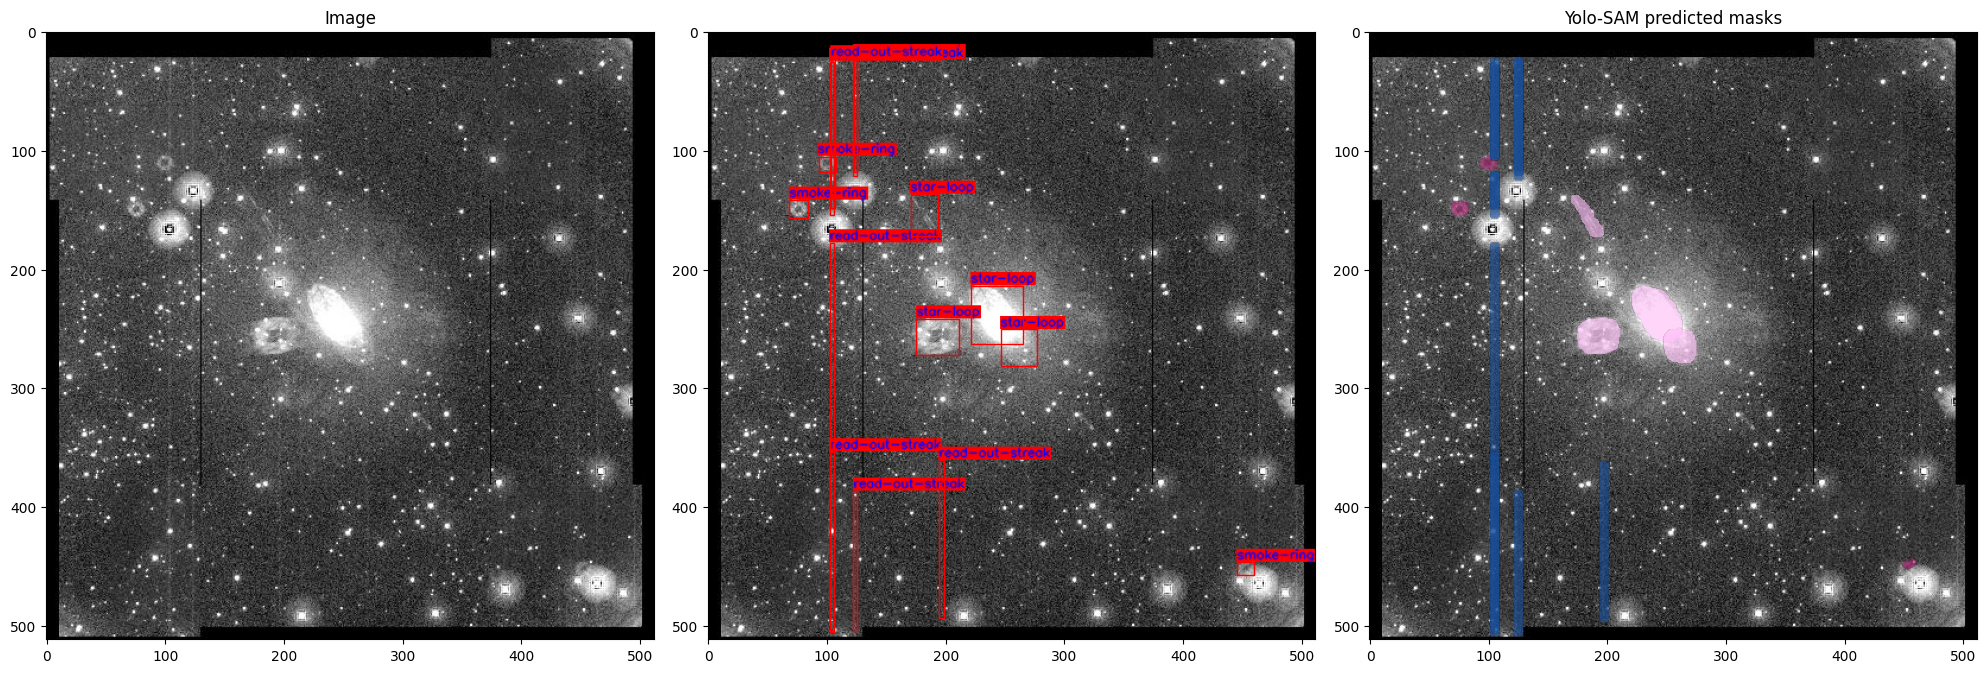

In [3]:
# masks = yolo_sam_pipeline.run_predict('../XAMI-dataset/xami_dataset/valid/S0743200101_V_png.rf.dba4ec263252737ec92121f599a4ca8b.jpg', show_masks=True)
masks = yolo_sam_pipeline.run_predict('./example_images/S0743200101_V.jpg', show_masks=True) 

**Inference on images from XMM Optical Monitor not used in our dataset.**

Number of object detected: 2
   central-ring
   star-loop


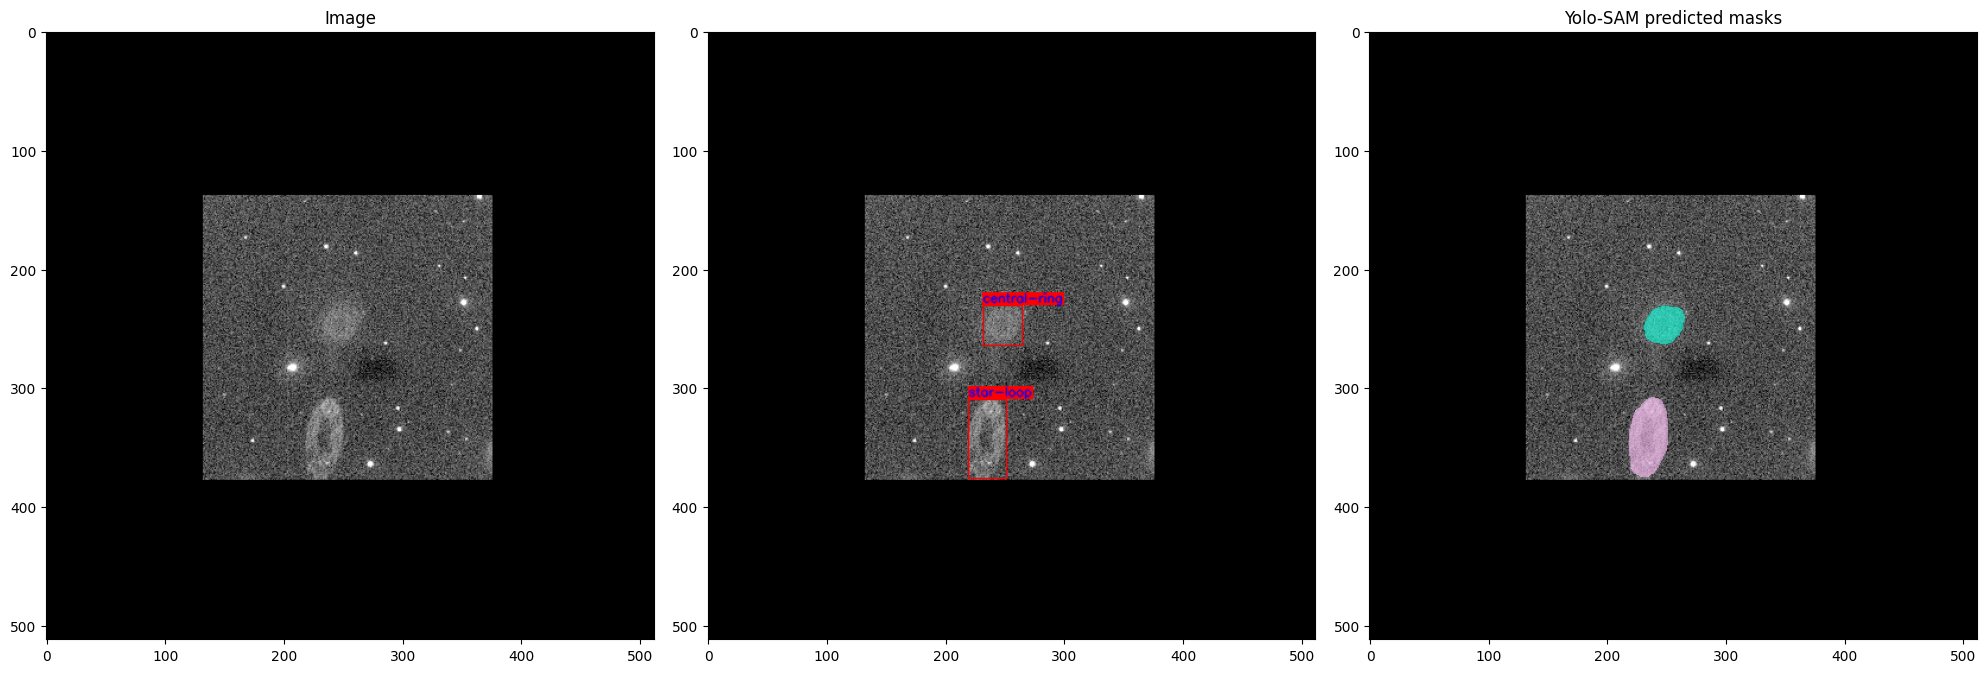

In [4]:
masks = yolo_sam_pipeline.run_predict('./example_images/S0893811101_M.png', show_masks=True) 

**inference on unseen images from other missions.**

Note: Unlike SAM, Yolov8 doesn't have Zero-Shot Learning capability. This results in a limitation to finding unseen artefacts due to bboxes generated by YOLO.

Number of object detected: 54
   read-out-streak


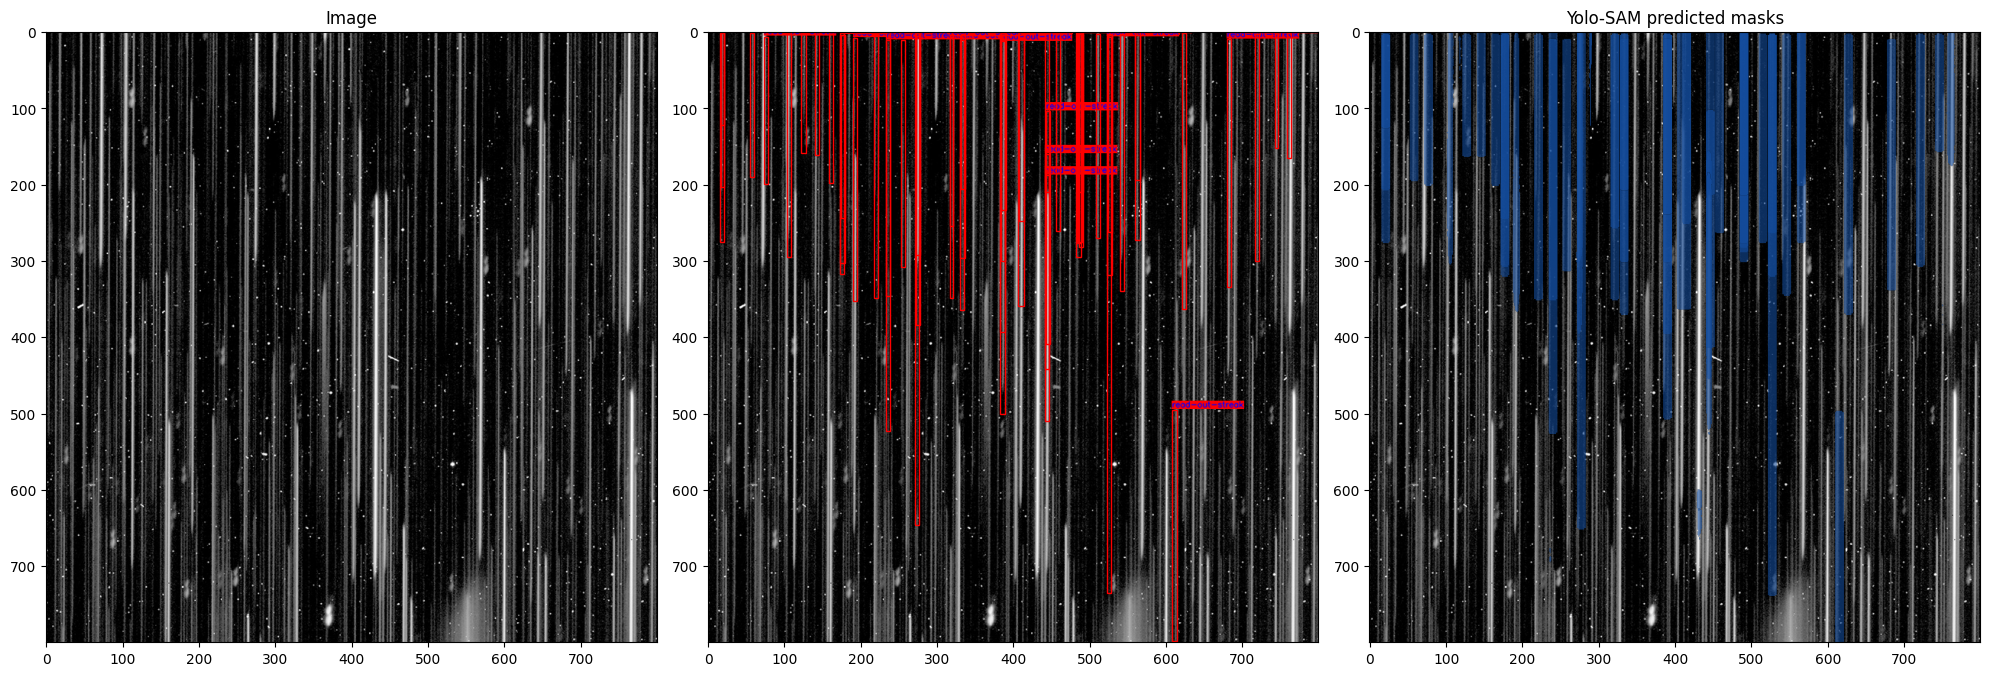

Number of object detected: 5
   other
   star-loop


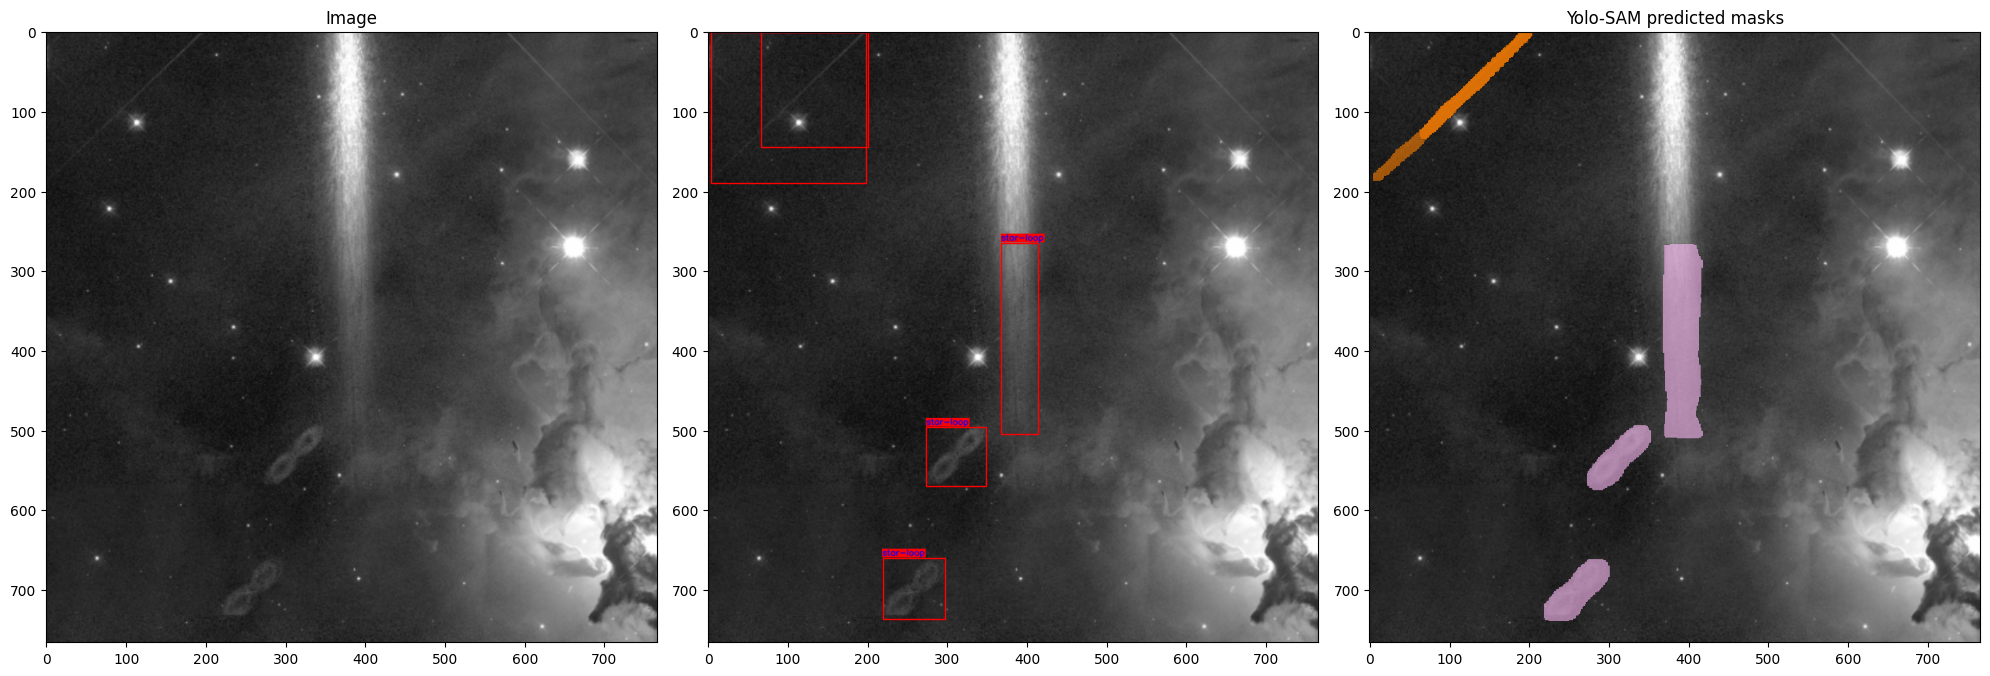

In [5]:
masks = yolo_sam_pipeline.run_predict('./example_images/Euclid_NISP_read_out_streaks.jpeg', yolo_conf=0.1, show_masks=True)
masks = yolo_sam_pipeline.run_predict('./example_images/Hubble_artefacts.png', yolo_conf=0.2, show_masks=True)